<a href="https://colab.research.google.com/github/TherealVL/ProyectoClima/blob/main/Proyecto_clima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto integrador**

**Objetivo del proyecto**

El propósito de este proyecto es obtener y analizar datos meteorológicos utilizando
la API de Open-Meteor, aplicar un proceso ETL en AWS y desarrollar un modelo de
aprendizaje automático para evaluar patrones climáticos para la colonia El Salado, Estado de México.

**Estructura del proyecto**

1.   Diseño de arquitectura
2.   Proceso ETL en AWS
3.   Análisis Exploratorio de Datos (EDA)
4.   Procesamiento de Datos
5.   Implementación de Modelo de Aprendizaje Automático
6.   Conclusiones




# 1. Diseño de arquitectura
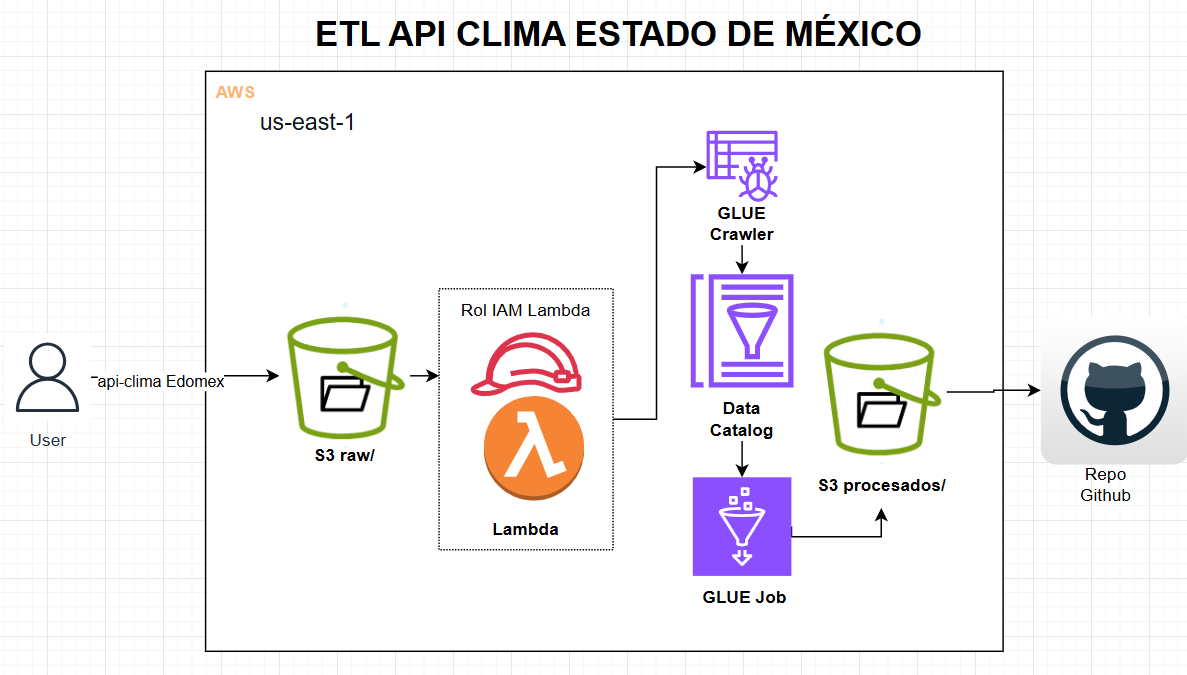

Explicación del diagrama ETL API CLIMA ESTADO DE MÉXICO

En este flujo, el usuario coloca el archivo .csv en la carpeta raw/ del bucket S3, lo que generará que el disparador asociado al rol IAM Lambda ejecute el código para transformar nuestros datos. Posteriormente, se ejecutará un GLUE crawler para que este identifique los esquemas del archivo y genere en Data Catalog una tabla que será nuestra fuente GLUE Job. Después de su ejecución, se cargará el archivo a la carpeta procesados/ y, finalmente, subiremos el archivo .csv a nuestra cuenta de Github para comenzar el análisis de datos.

# **2. Proceso ETL en AWS**

## Creación del bucket S3 vl-datos-clima con dos carpertas


*   processed/
*   raw/   

  *nota en la carpeta raw  subirmos nuestro  archivo .csv para comenzar el ETL*



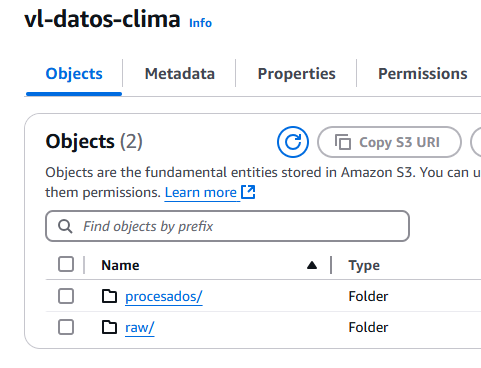

## Configuración de Lambda


*   Configuración de las capas boto3, request, pandas
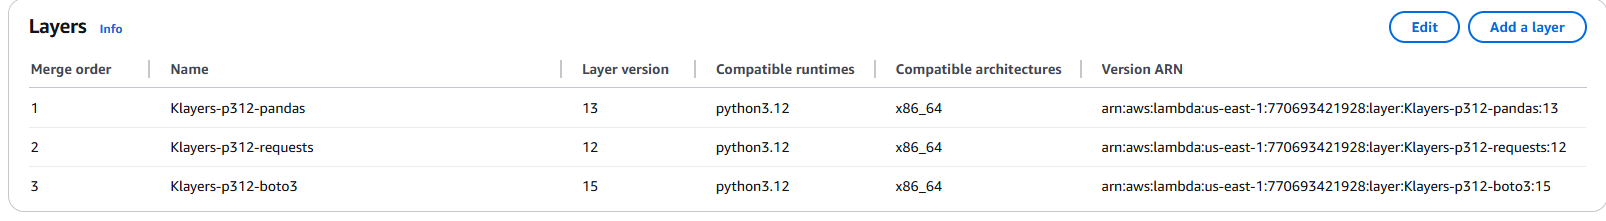
*   Modificación de rol para modificar, insertar, leer y listar

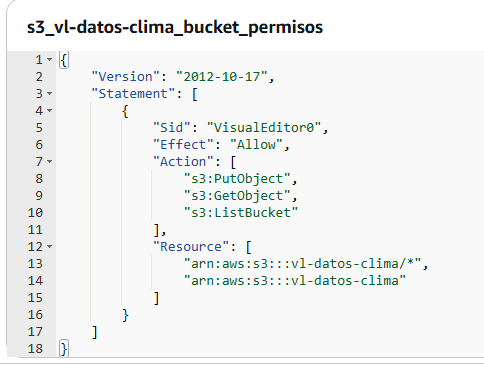

* Configurar variable de entorno
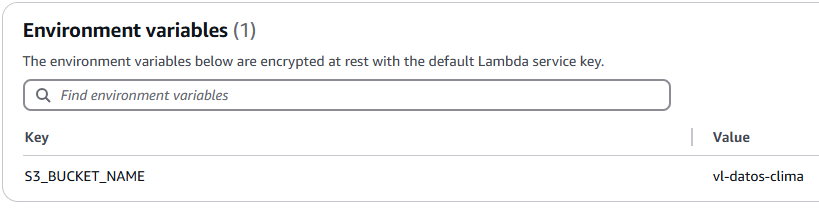
* Modificación del timmeout a 30 segundos

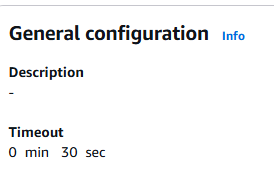


* Despligue de Lambda

In [ ]:
import json
import requests
import pandas as pd
import boto3
import os
from datetime import datetime

def lambda_handler(evento, contexto):
    # Parámetros de la API (ubicación: El Salado Estado de México)
    latitude = 19.37298702176229
    longitude = -98.9620234192742
    timeZone = "America/Mexico_City"

    # Período: Enero de 2022 a diciembre 2024
    years = [2022,2023, 2024]
    months = ["01","02","03","04","05","06","07","08","09","10","11","12"]

    # Lista de parámetros a solicitar
    daily_params = "temperature_2m_max,temperature_2m_min,temperature_2m_mean,rain_sum,precipitation_hours,wind_speed_10m_max,shortwave_radiation_sum"

    # Lista para almacenar DataFrames
    dataframes = []

    for year in years:
        for month in months:
            # Solicitud a la API de Open-Meteo para obtener los datos históricos
            url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={year}-{month}-01&end_date={year}-{month}-31&timezone={timeZone}&daily={daily_params}"

            respuesta = requests.get(url)

            if respuesta.status_code == 200:
                # Convertir la respuesta JSON en un diccionario
                datos = respuesta.json()

                # Convertir la parte de "daily" en un DataFrame
                df_year = pd.DataFrame(datos["daily"])

                # Convertir la columna 'time' a datetime
                df_year["time"] = pd.to_datetime(df_year["time"])

                # Extraer año, mes y día correctamente desde la columna 'time'
                df_year["year"] = df_year["time"].dt.year
                df_year["month"] = df_year["time"].dt.month  # Corregido para extraer el mes real
                df_year["day"] = df_year["time"].dt.day  # Extraer día correctamente

                # Agregar el DataFrame a la lista
                dataframes.append(df_year)
                print(f"Datos obtenidos para el año {year}.")
            else:
                print(f"Error al consultar los datos para el año {year}. Código de estado: {respuesta.status_code}")

    # Unir los datos en un solo DataFrame
    df_datosDiarios = pd.concat(dataframes, ignore_index=True)

    # Guardar datos en un bucket de S3
    s3 = boto3.client("s3")
    nombre_bucket = os.environ.get("S3_BUCKET_NAME")  # Obtener nombre del bucket de variables de entorno
    nombre_archivo = f"datosClimaticos_{datetime.now().strftime('%Y-%m-%d')}.csv"

    # Convertimos el dataframe en un archivo CSV
    buffer_csv = df_datosDiarios.to_csv(index=False)
    s3.put_object(Bucket=nombre_bucket, Key=nombre_archivo, Body=buffer_csv)

    return {
        "statusCode": 200,
        "body": json.dumps(f"Archivo {nombre_archivo} guardado en S3 correctamente.")
    }

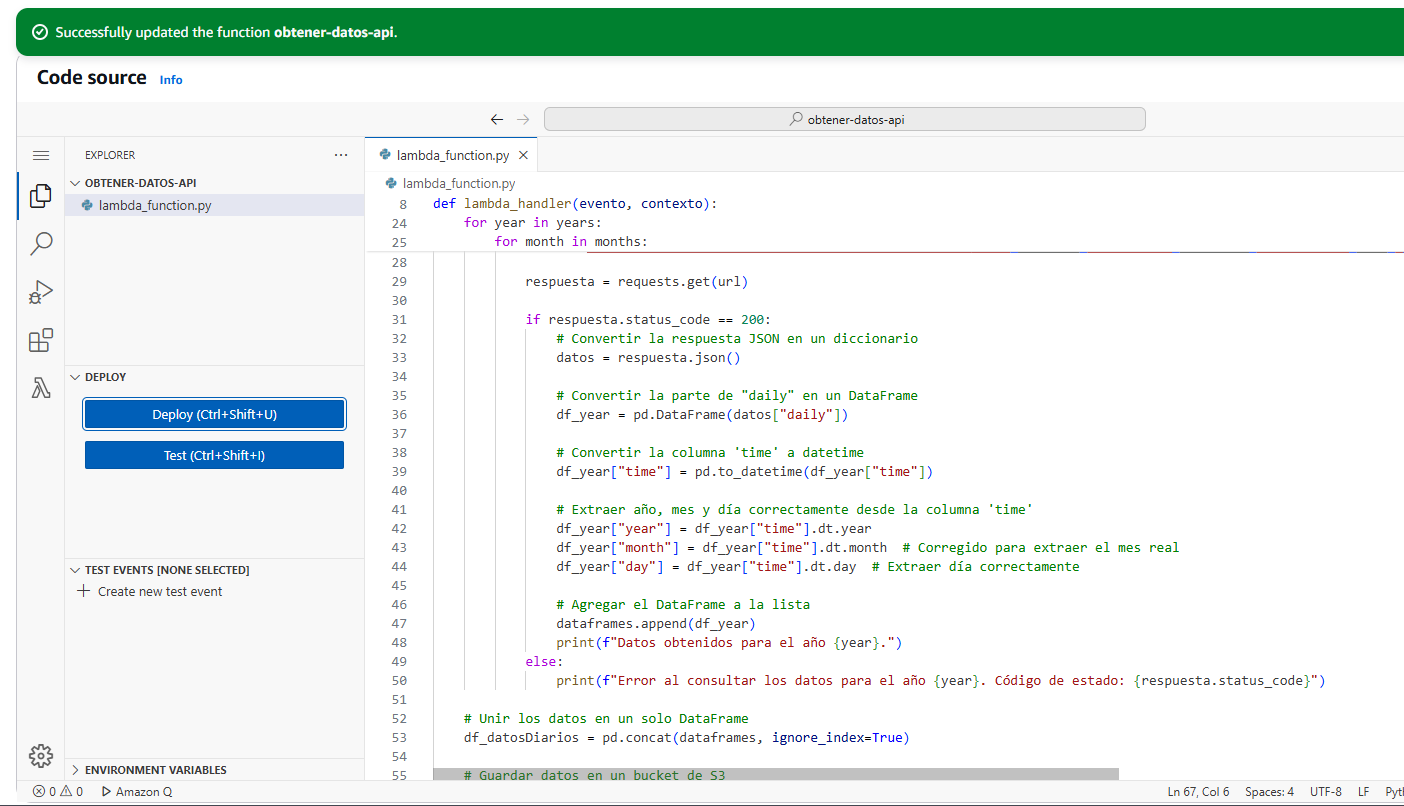

# Configuración de GLUE crawler, datacatalog y job



*   Configuración y ejecución de Craweler
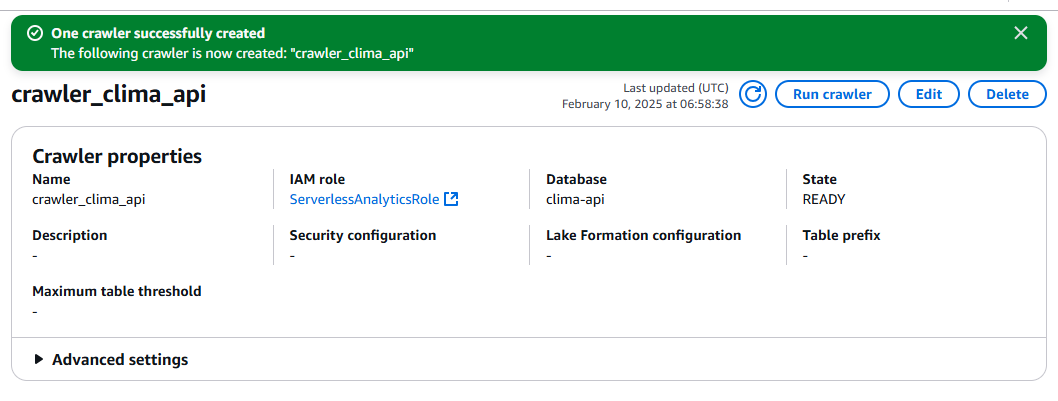

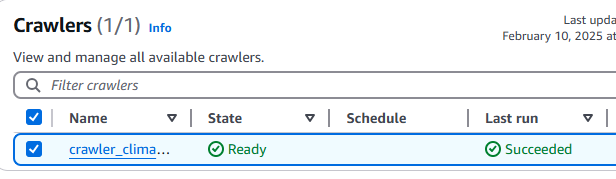






* Comprobamos la creación de tabla


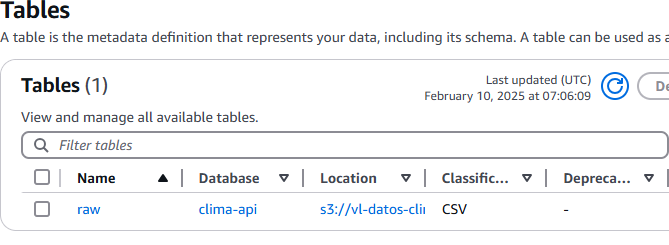

* Configuración GLUE ETL JOB

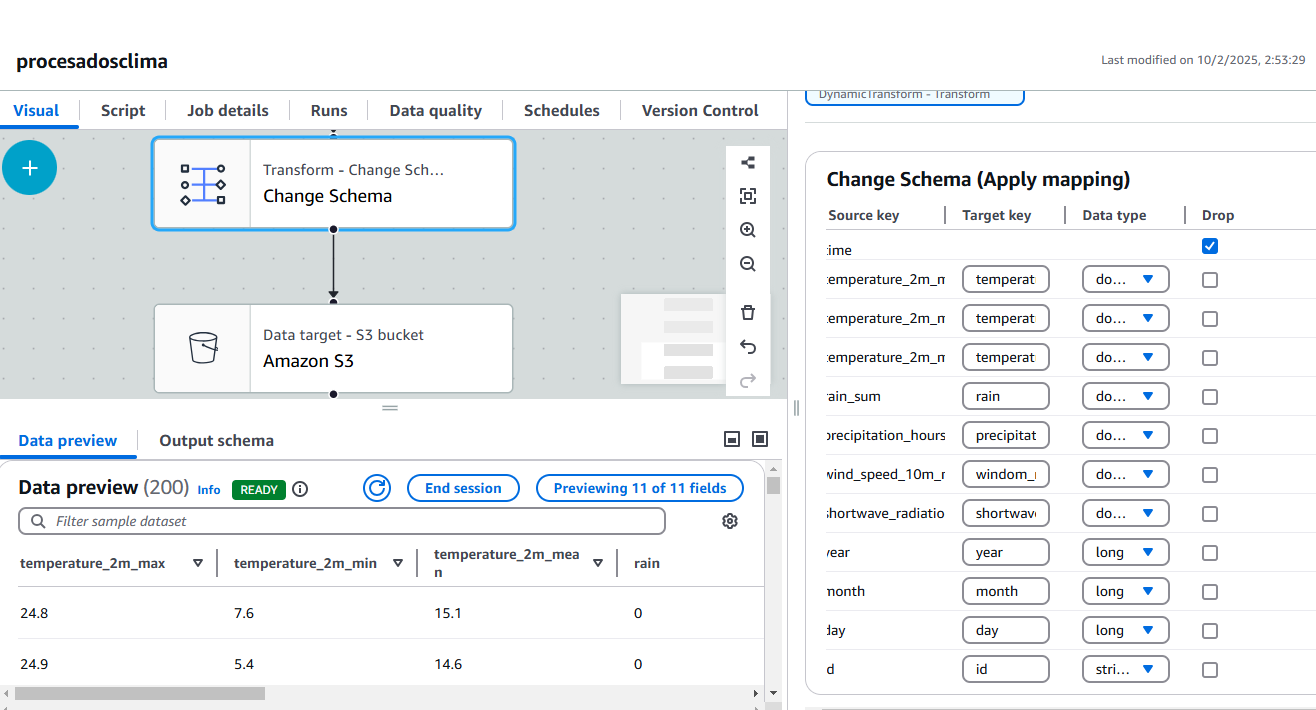


* Ejecución de GLUE JOB

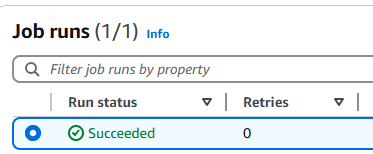

* Comprobamos la creación del archivo en nuestra caperta procesados/

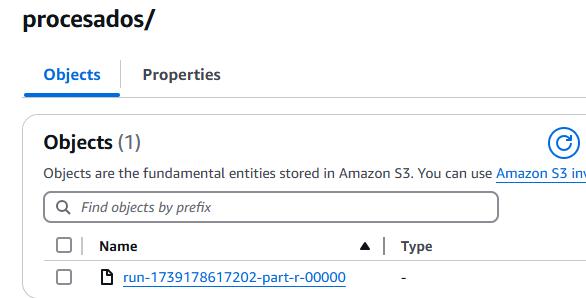

* Cargar archivo generado a nuestra cuenta Github

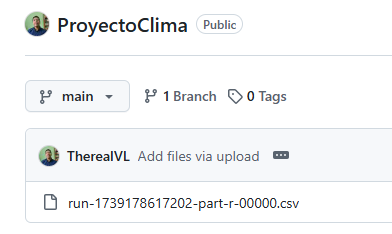


# 3. Análisis Exploratorio de Datos (EDA)


In [12]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:

url = "https://raw.githubusercontent.com/TherealVL/ProyectoClima/refs/heads/main/run-1739178617202-part-r-00000.csv"
df_clima = pd.read_csv(url)
df_clima.head()

,temperature_2m_max,temperature_2m_min,temperature_2m_mean,rain,precipitation,windom_max,shortwave_radiation_sum,year,month,day,id
0,24.8,7.6,15.1,0.0,0.0,12.3,20.65,2022,1,1,70dd86d8-2e5f-4de1-bb6f-a3dd9cf4bd6d
1,24.9,5.4,14.6,0.0,0.0,17.0,20.01,2022,1,2,25b0d197-c65f-44a2-b024-bd89c048021d
2,21.8,6.5,12.8,0.0,0.0,18.2,18.23,2022,1,3,c17cc8a1-e974-4c20-9b12-d2be1ae87248
3,24.1,5.6,14.8,0.0,0.0,18.2,20.42,2022,1,4,eb9f44df-dec0-4c38-a9dd-1906404487d7
4,24.9,6.2,15.5,0.0,0.0,23.7,19.99,2022,1,5,7731c4aa-016d-42b8-9539-51fc70b4072d


In [48]:
# Renombrar columnas para mayor claridad
df_clima.rename(columns={
    "temperature_2m_max": "temperatura_máxima",
    "temperature_2m_min": "temperatura_minima",
    "temperature_2m_mean": "temperatura_promedio",
    "rain":"lluvia",
    "precipitation": "Horas de precipitación",
    "windom_max": "Velocidad máxima del viento a 10m",
    "shortwave_radiation_sum": "radiación solar"
}, inplace=True)

In [49]:
df_clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1116 entries, 0 to 1115
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   temperatura_máxima                 1116 non-null   float64
 1   temperatura_minima                 1116 non-null   float64
 2   temperatura_promedio               1116 non-null   float64
 3   lluvia                             1116 non-null   float64
 4   Horas de precipitación             1116 non-null   float64
 5   Velocidad máxima del viento a 10m  1116 non-null   float64
 6   radiación solar                    1116 non-null   float64
 7   year                               1116 non-null   int64  
 8   month                              1116 non-null   int64  
 9   day                                1116 non-null   int64  
 10  id                                 1116 non-null   object 
dtypes: float64(7), int64(3), object(1)
memory usage: 96.0+ K

In [31]:
# Número de registros duplicados
num_duplicados = df_clima.duplicated().sum()
print(f"Número de registros duplicados: {num_duplicados}")

Número de registros duplicados: 0


In [50]:
# Lista de columnas numéricas
numerical_columns = ["temperatura_máxima", "temperatura_minima", "temperatura_promedio", "lluvia", "Velocidad máxima del viento a 10m", "radiación solar"]


In [51]:
# Revisar estadísticas básicas del dataframe
df_clima.describe()

,temperatura_máxima,temperatura_minima,temperatura_promedio,lluvia,Horas de precipitación,Velocidad máxima del viento a 10m,radiación solar,year,month,day
count,1116.000000,1116.000000,1116.000000,1116.000000,1116.000000,1116.000000,1116.000000,1116.000000,1116.000000,1116.000000
mean,24.513351,10.527867,16.966667,1.696953,2.551971,19.146864,22.300914,2023.000000,6.517921,15.474910
std,3.393493,2.640608,2.593251,3.855499,4.014546,5.920565,4.366831,0.816863,3.449916,8.932849
min,13.800000,1.100000,9.400000,0.000000,0.000000,5.900000,5.830000,2022.000000,1.000000,1.000000
25%,22.000000,8.700000,15.300000,0.000000,0.000000,14.400000,19.535000,2022.000000,3.750000,8.000000
50%,24.100000,10.900000,16.750000,0.000000,0.000000,18.750000,22.265000,2023.000000,7.000000,15.000000
75%,26.800000,12.500000,18.425000,1.200000,4.000000,23.800000,25.762500,2024.000000,10.000000,23.000000
max,34.700000,17.000000,24.900000,29.700000,24.000000,41.500000,31.710000,2024.000000,12.000000,31.000000


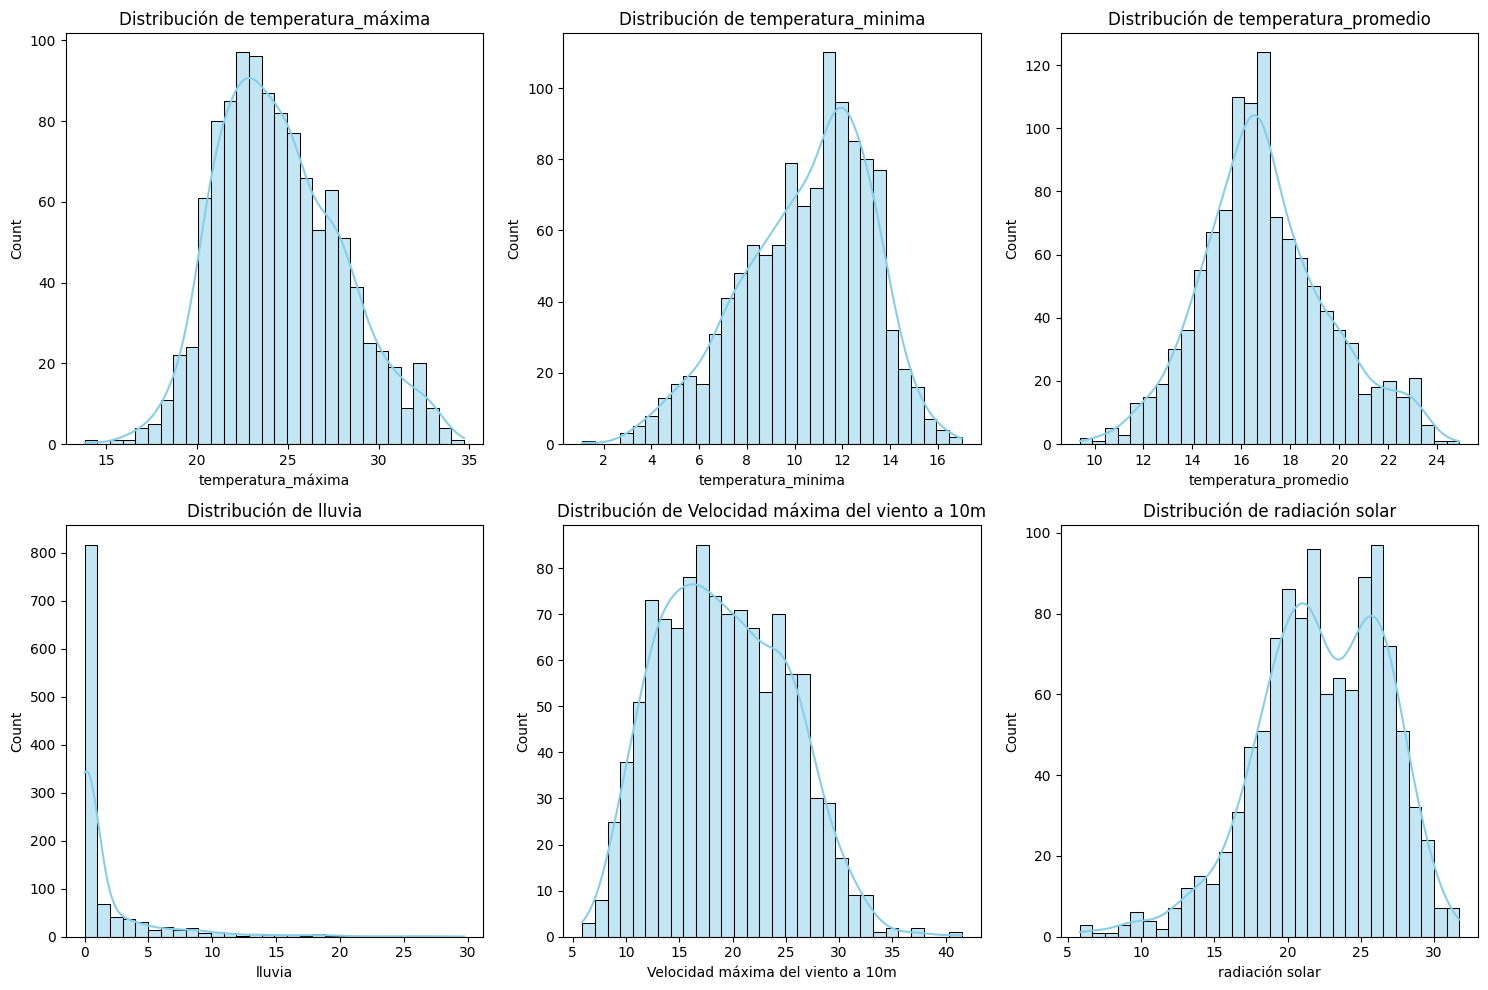

In [52]:
# Configuran el tamaño del gráfico
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_clima[col].dropna(), kde=True, bins=30, color="skyblue")
    plt.title(f'Distribución de {col}')

plt.tight_layout()
plt.show()

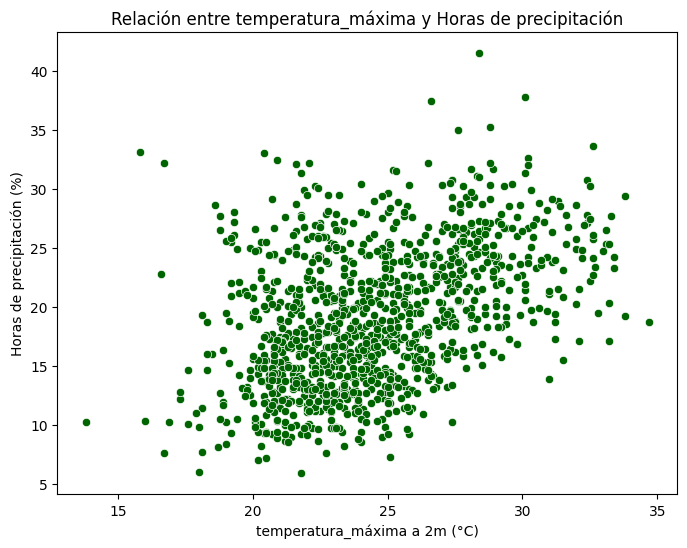

In [72]:

# Ejemplo: Scatter plot de temperatura_máxima vs Horas de precipitación
# El contraste debe de ser entre dos variables numéricas o una numérica y otra categórica
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_clima, x="temperatura_máxima", y="Velocidad máxima del viento a 10m", color="darkgreen")
plt.title('Relación entre temperatura_máxima y Horas de precipitación')
plt.xlabel("temperatura_máxima a 2m (°C)")
plt.ylabel("Horas de precipitación (%)")
plt.show()

# 4. Implementación de Modelo de Aprendizaje Automático

# 5.Conclusiones